# Setup

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys, os

# handle image display
from IPython.display import display, HTML
import base64
from pathlib import Path
from PIL import Image, ImageChops, ImageEnhance

sys.path.insert(0, os.path.abspath(os.path.join(".."))) # path to hammock_plot module
import hammock_plot

## Instructions:
When you have code that is logically correct, you can change GENERATE_EXPECTED to True to create baseline copies of the images for comparison
When you're running tests, set it to False to allow for side-by-side comparison.

In [2]:
GENERATE_EXPECTED = False 
# True: replaces reference images using current hammock_plot.py
# False: runs tests
# toggle on or off

EXPECTED_PATH=os.path.abspath("expected_plots")
RESULT_PATH=os.path.abspath("test_plots")
os.makedirs(RESULT_PATH, exist_ok=True) # make sure that the RESULT_PATH directory exists

Dataframe set up

In [3]:
# set up dataframes
DATA_DIR = os.path.abspath(os.path.join("..", "data"))
df_asthma = pd.read_csv(os.path.join(DATA_DIR, "data_asthma.csv"))
df_diabetes = pd.read_csv(os.path.join(DATA_DIR, "data_diabetes.csv"))
df_asthma_2 = pd.read_csv(os.path.join(DATA_DIR, "data_asthma_2.csv")) #.dropna().iloc[:20, :] # trim so it runs faster
df_shakespeare = pd.read_csv(os.path.join(DATA_DIR, "data_shakespeare.csv"))
df_penguins = pd.read_csv(os.path.join(DATA_DIR, "data_penguins.csv"))

# Error handling tests
Testing the inputs that should throw errors

Helper function to deal with errors

In [4]:
def run_error_check(plot_func_error, expected_msg = None):
    try:
        plot_func_error()
        print("Test failed: No error was thrown")
    except Exception as e: # general catch
        error_message = str(e)
        if expected_msg is None or expected_msg == error_message:
            print(f"Test success!\nAs desired, error: {error_message}")
        else:
            print(f"Test failed:\nActual error '{error_message}' differs from the expected error '{expected_msg}'.")

### Empty dataframe

In [5]:
run_error_check(lambda: hammock_plot.Hammock(pd.DataFrame()), "data_df must be provided and non-empty.")

Test success!
As desired, error: data_df must be provided and non-empty.


### No variable names passed

In [6]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(),
    f"There must be some variable names passed to the argument 'var'."
)

Test success!
As desired, error: There must be some variable names passed to the argument 'var'.


### Invalid variable name passed

In [7]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["hospitalizations", "group", "airplane"],
    ),
    "the variables: {'airplane'} in var_lst is not in data or value names user given does not match the data "
)

Test success!
As desired, error: the variables: {'airplane'} in var_lst is not in data or value names user given does not match the data 


### Invalid variable name passed to numerical_var_levels dictionary

In [8]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["hospitalizations", "group", "gender"],
        numerical_var_levels={"hospitalizations": 4, "airplane": 5}
    ),
    "The value: {'airplane'} in numerical_var_levels is not in data."
)

Test success!
As desired, error: The value: {'airplane'} in numerical_var_levels is not in data.


### Specify categorical-type data to have interval-based labels

In [9]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["hospitalizations", "group", "gender"],
        numerical_var_levels={"hospitalizations": 4, "group": 5}
    ),
    "group is a categorical data type and thus cannot belong to numerical_var_levels"
)

Test success!
As desired, error: group is a categorical data type and thus cannot belong to numerical_var_levels


### numerical_var_levels given invalid tick specification

In [10]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["hospitalizations", "group", "gender", "comorbidities"],
        numerical_var_levels={"hospitalizations": 5, "comorbidities": 3.2}
    ),
    "You can only specify integer values or None for the number of levels for variables labeled by intervals"
)

Test success!
As desired, error: You can only specify integer values or None for the number of levels for variables labeled by intervals


### numerical_var_levels given invalid tick specification 2

In [11]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["hospitalizations", "group", "gender", "comorbidities"],
        numerical_var_levels={"hospitalizations": 5, "comorbidities": -5}
    ),
    "Levels must be nonnegative: error with pair (comorbidities, -5)"
)

Test success!
As desired, error: Levels must be nonnegative: error with pair (comorbidities, -5)


### 'colors' argument is not a list of strings

In [12]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["group", "gender"],
        hi_var="group",
        hi_value=["adult", "child"],
        colors=["red", 2]
    )
)

Test success!
As desired, error: Argument "colors" must be a list of str.


In [13]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["group", "gender"],
        hi_var="group",
        hi_value=["adult", "child"],
        colors=["red", (1,2)]
    ),
    f'Argument "colors" must be a list of str.'
)

Test success!
As desired, error: Argument "colors" must be a list of str.


### invalid variable name in same_scale list
User's request to use the same scale for specific variables includes variables that are not in the data

In [14]:
hammock = hammock_plot.Hammock(df_diabetes)
run_error_check(
    lambda: hammock.plot(
        var=list(df_diabetes),
        same_scale=["sataces", "hi"]
    ),
    "the variables: {'hi'} in same_scale is not in var_lst or value names user given does not match the data "
)

Test success!
As desired, error: the variables: {'hi'} in same_scale is not in var_lst or value names user given does not match the data 


### invalid variable name in same_scale list - not in var_lst
User's request to use the same scale for specific variables includes variables that are not in the specified var_lst

In [15]:
hammock = hammock_plot.Hammock(df_diabetes)
run_error_check(
    lambda: hammock.plot(
        var=["sataces", "satrate"],
        same_scale=["sataces", "satcomm"]
    ),
    "the variables: {'satcomm'} in same_scale is not in var_lst or value names user given does not match the data "
)

Test success!
As desired, error: the variables: {'satcomm'} in same_scale is not in var_lst or value names user given does not match the data 


### same_scale is specified across numerical and categorical data

In [16]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["comorbidities", "group", "gender"],
        same_scale=["comorbidities", "group"],
    ),
    "Variables in same_scale must either all be numerical or all be categorical."
)

Test success!
As desired, error: Variables in same_scale must either all be numerical or all be categorical.


### invalid variable in value_order

In [17]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["comorbidities", "group", "gender"],
        value_order={"group": ["child", "adolescent", "adult"], "airplane": ["1", "2", "3"]}
    ),
    "the variables: {'airplane'} in value_order is not in var_lst or value names user given does not match the data "
)

Test success!
As desired, error: the variables: {'airplane'} in value_order is not in var_lst or value names user given does not match the data 


### invalid variable name

In [18]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["group", "gender", "vehicle"]
    ),
    "the variables: {'vehicle'} in var_lst is not in data or value names user given does not match the data "
)

Test success!
As desired, error: the variables: {'vehicle'} in var_lst is not in data or value names user given does not match the data 


### invalid variable name to highlight

In [19]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["group", "gender"],
        hi_var="vehicle",
        hi_value=["airplane", "bicycle"]
    ),
    "highlight variable is not in data. "
)

Test success!
As desired, error: highlight variable is not in data. 


### no values provided to highlight

In [20]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["group", "gender"],
        hi_var="group"
    ),
    "hi_value or hi_missing must be speicified as hi_var is given."
)

Test success!
As desired, error: hi_value or hi_missing must be speicified as hi_var is given.


### invalid value name in hi_value

In [21]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["group", "gender"],
        hi_var="group",
        hi_value=["adult", "parent"]
    ),
    "The value(s): {'parent'} in hi_value is not in data."
)

Test success!
As desired, error: The value(s): {'parent'} in hi_value is not in data.


### highlight colour list includes default colour

In [22]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["group", "gender"],
        hi_var="group",
        hi_value=["adult", "child"],
        colors=["red", "#a6cee3"]
    ),
    "The current highlight colors ['red', '#a6cee3'] conflict with the default color #a6cee3. Please choose another default color or other highlight colors"
)

Test success!
As desired, error: The current highlight colors ['red', '#a6cee3'] conflict with the default color #a6cee3. Please choose another default color or other highlight colors


In [23]:
hammock = hammock_plot.Hammock(df_asthma)
run_error_check(
    lambda: hammock.plot(
        var=["group", "gender"],
        hi_var="group",
        hi_value=["adult", "child"],
        colors=["red", "grey"],
        default_color="grey",
    ),
    "The current highlight colors ['red', 'grey'] conflict with the default color grey. Please choose another default color or other highlight colors"
)

Test success!
As desired, error: The current highlight colors ['red', 'grey'] conflict with the default color grey. Please choose another default color or other highlight colors


# General tests
Test cases involving "general" hammock plot methods (following the categories in README.md)

Helper function to display results

In [24]:
def show_expected_vs_actual(title, filename):
    """
    Compare expected vs actual images.
    If they differ, display them side by side and show a diff image below.
    """
    def encode_image(path):
        path = Path(path)
        if not path.exists():
            return None
        with open(path, "rb") as f:
            data = f.read()
        return base64.b64encode(data).decode("utf-8")

    def images_differ(img1_path, img2_path):
        """Return (bool, diff_image) where diff_image highlights changes."""
        try:
            img1 = Image.open(img1_path).convert("RGB")
            img2 = Image.open(img2_path).convert("RGB")
        except Exception:
            return True, None  # couldn't open or mismatch

        if img1.size != img2.size:
            return True, None

        diff = ImageChops.difference(img1, img2)
        if diff.getbbox() is None:
            return False, None

        # Enhance the difference for visibility
        enhancer = ImageEnhance.Brightness(diff)
        diff_enhanced = enhancer.enhance(3.0)
        return True, diff_enhanced

    expected_file = os.path.join(EXPECTED_PATH, filename)
    result_file = os.path.join(RESULT_PATH, filename)

    if not os.path.exists(result_file):
        print(f"Error: test_plots directory doesn’t contain {filename}")
        return
    if not os.path.exists(expected_file):
        print(f"Error: expected_plots directory doesn’t contain {filename}")
        return

    differ, diff_img = images_differ(expected_file, result_file)

    if differ:
        print(f"Test failed: Significant difference found in {title}")

        expected_b64 = encode_image(expected_file)
        result_b64 = encode_image(result_file)

        # Save the diff image temporarily to encode it
        diff_b64 = ""
        if diff_img:
            diff_temp_path = "_temp_diff.png"
            diff_img.save(diff_temp_path)
            diff_b64 = encode_image(diff_temp_path)
            os.remove(diff_temp_path)

        html_content = f"""
        <div style="text-align: center; margin-bottom: 10px;">
            <h3>{title}</h3>
        </div>
        <div style="display: flex; flex-wrap: wrap; justify-content: center; gap: 10px; align-items: flex-start;">
            <div style="flex: 1 1 48%; text-align: center;">
                <div style="font-weight: bold;">Expected</div>
                <img src="data:image/png;base64,{expected_b64}" style="width: 100%; height: auto; border: 1px solid #ccc;">
            </div>
            <div style="flex: 1 1 48%; text-align: center;">
                <div style="font-weight: bold;">Actual</div>
                <img src="data:image/png;base64,{result_b64}" style="width: 100%; height: auto; border: 1px solid #ccc;">
            </div>
        </div>
        """

        if diff_b64:
            html_content += f"""
            <div style="margin-top: 20px; text-align: center;">
                <div style="font-weight: bold;">Difference</div>
                <img src="data:image/png;base64,{diff_b64}" style="max-width: 80%; height: auto; border: 1px solid #ccc;">
            </div>
            """

        display(HTML(html_content))

    else:
        print(f"{title}: No visual differences detected")

## Continuous Data

In [25]:
# highlight - modified default colour
filename = "continuous.png"
df = df_asthma_2

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var= ["Age", "Gender", "Smoking", "PhysicalActivity", "FamilyHistoryAsthma"],
    display_figure=False,
    hi_var="PhysicalActivity",
    hi_value="2<x<3.5",
    missing=True,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename),
    display_type={"PhysicalActivity": "violin","Age":"box","Gender":"box","Smoking":"box","FamilyHistoryAsthma":"box"},
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Continuous Data Test", filename)

Continuous Data Test: No visual differences detected


## Boxplot Highlighting

Test failed: Significant difference found in Continuous Data Test



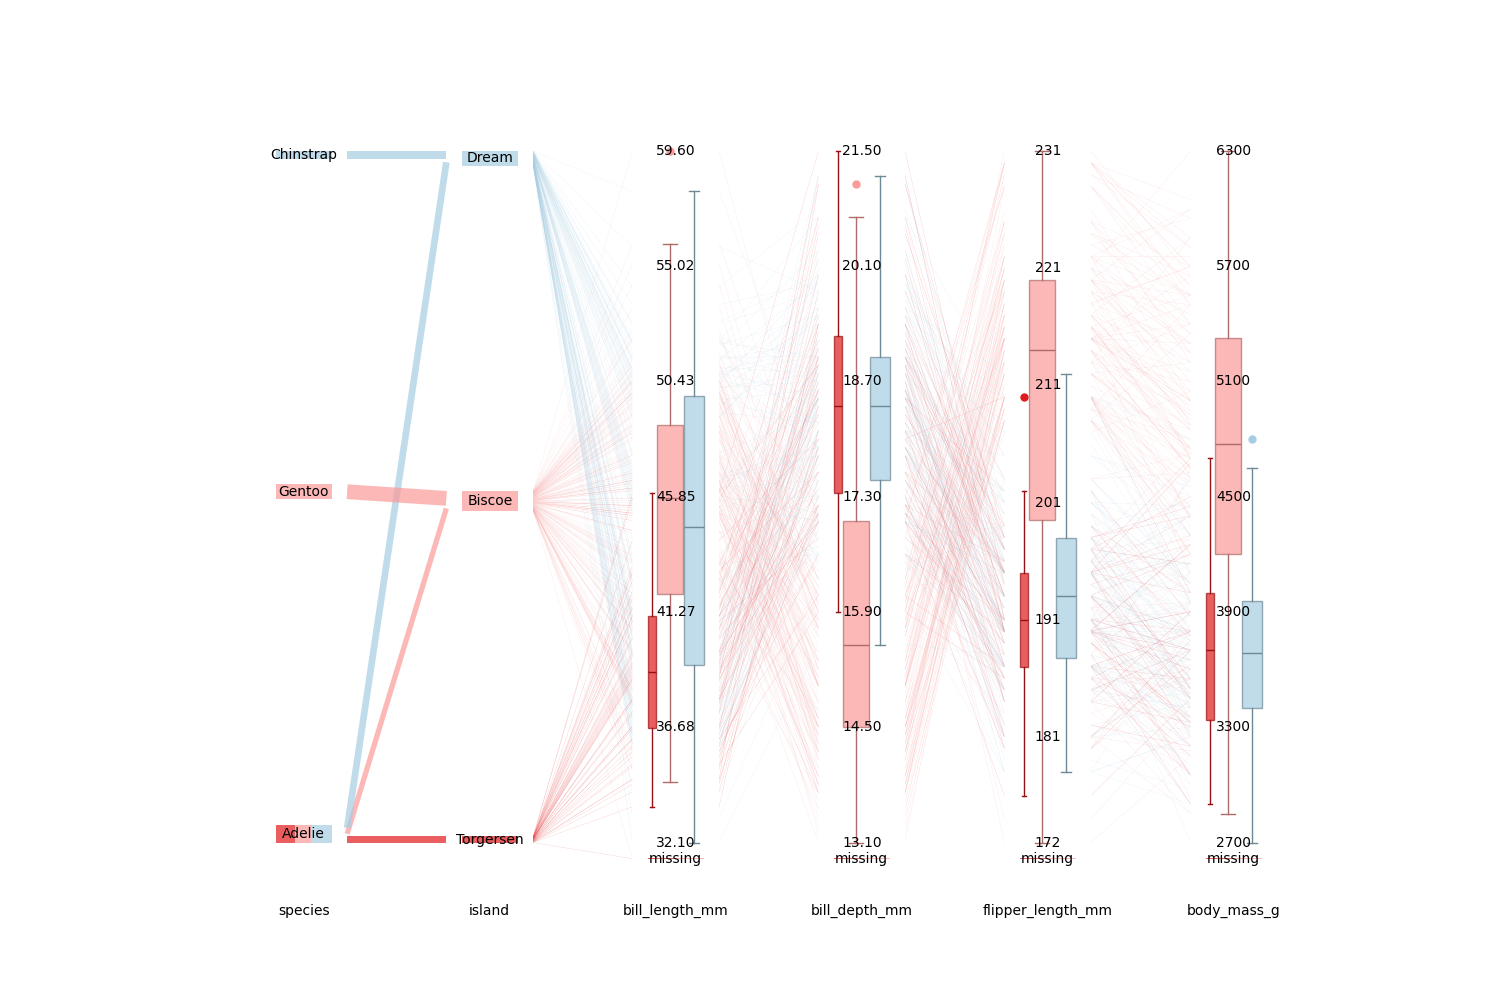
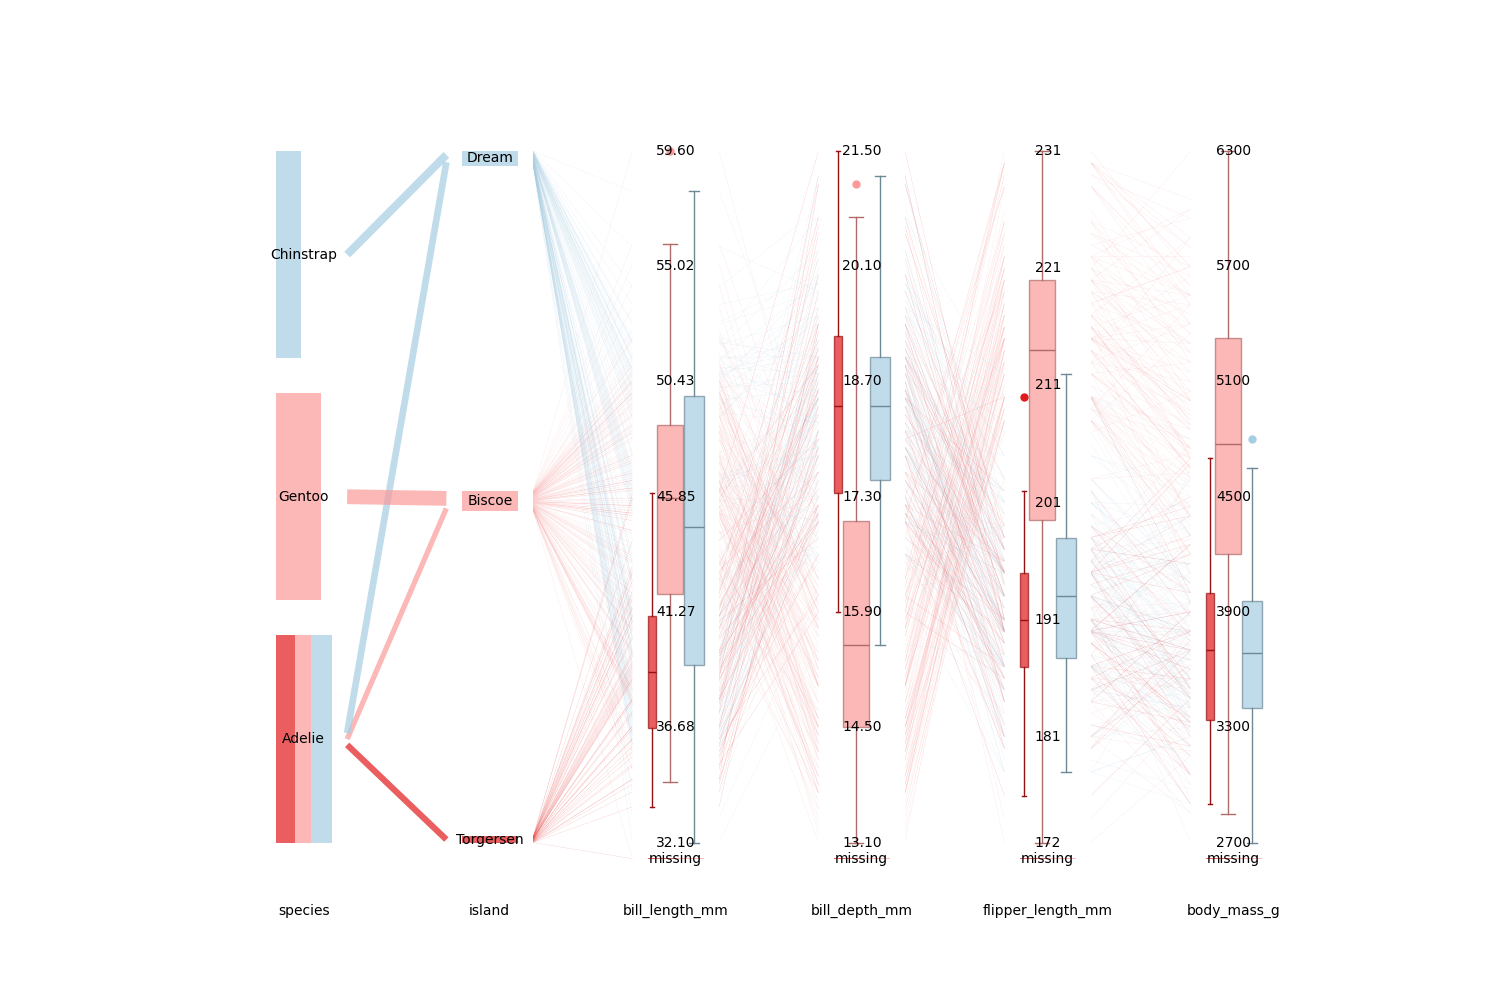
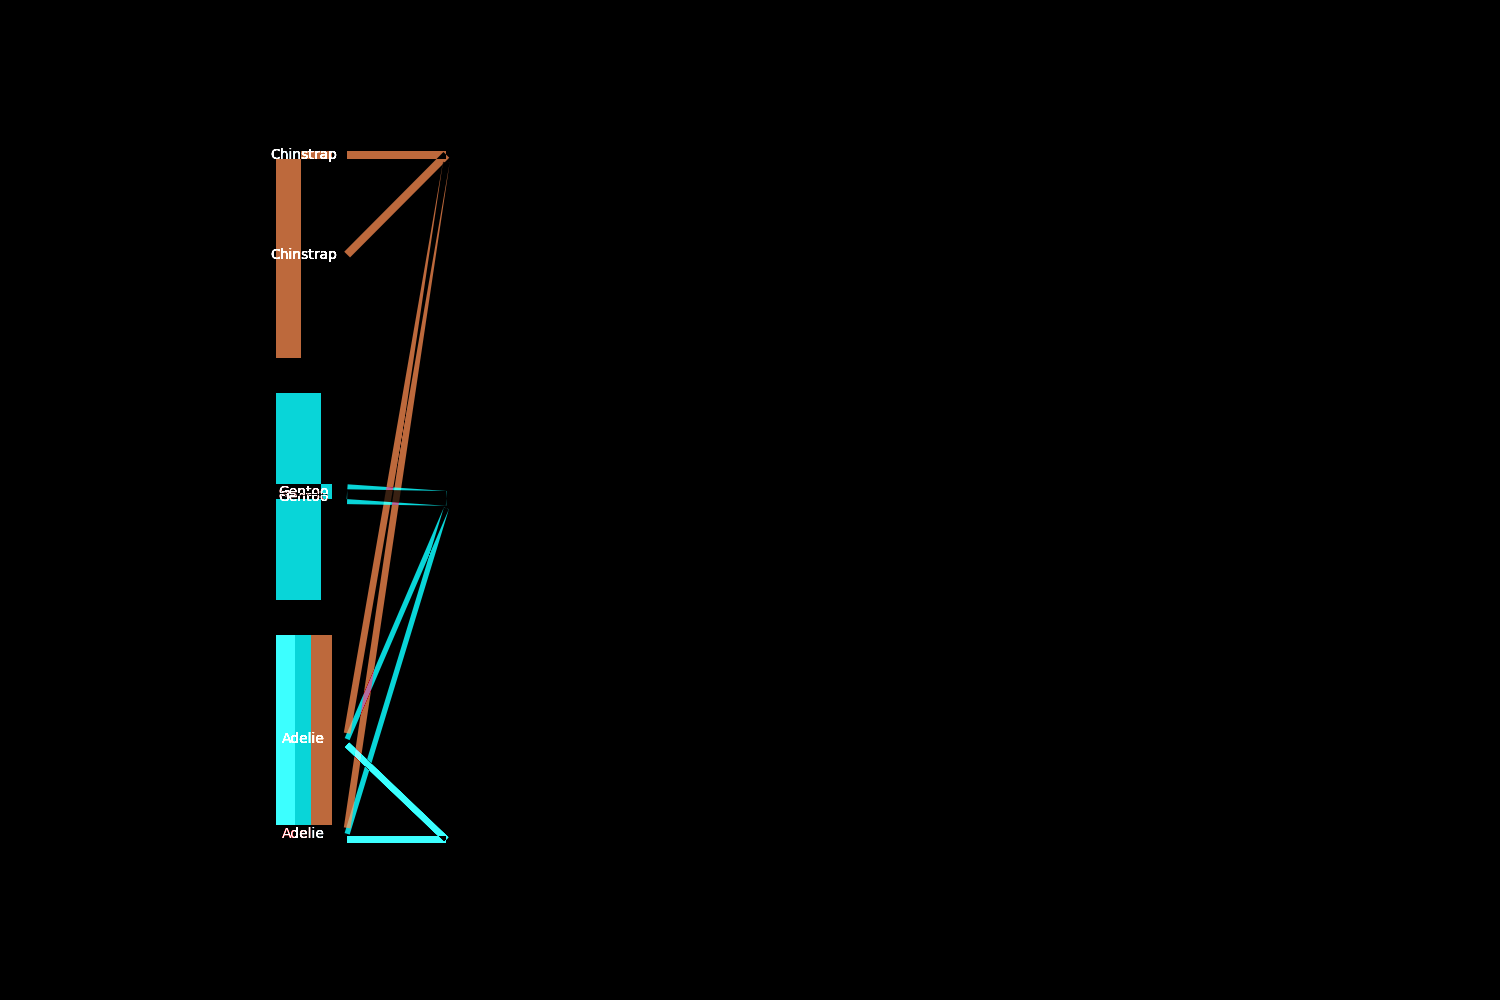

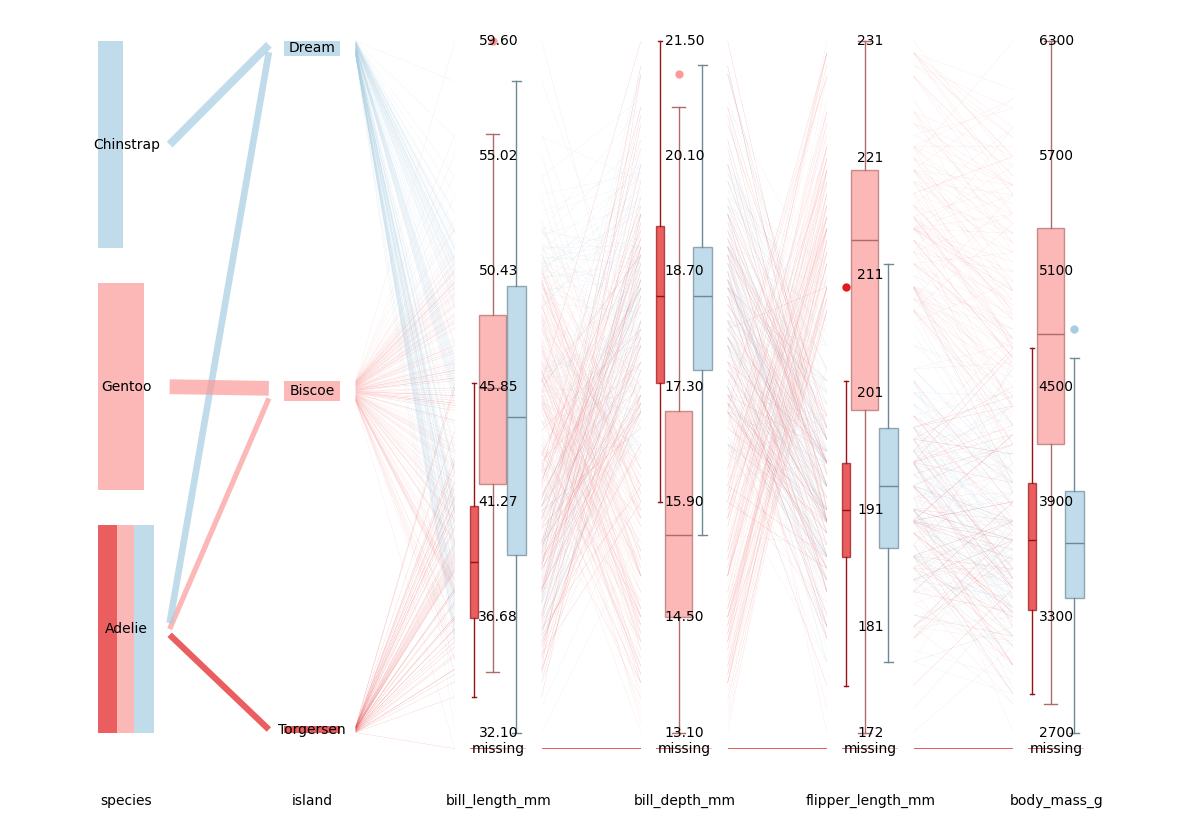

In [26]:
filename = "box-mult-highlight.png"
df = df_penguins

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var= ["species", "island", "bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"],
    display_figure=True,
    hi_var="island",
    hi_value=["Torgersen", "Biscoe"],
    missing=True,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename),
    display_type={"bill_length_mm":"box", "bill_depth_mm": "box", "flipper_length_mm": "box", "body_mass_g":"box", "species": "bar chart"},
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Continuous Data Test", filename)

## Var List

In [27]:
# general - var list
filename = "varlist.png"
var = ["gender", "group", "hospitalizations"]
df = df_asthma

hammock = hammock_plot.Hammock(df)
hammock.plot(
    var=var,
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Variable List Test", filename)

Variable List Test: No visual differences detected


## Value Ordering

In [28]:
# general - value ordering
filename = "val_order.png"
value_order = {"group": ["adolescent", "child", "adult"]}
df = df_asthma
hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    value_order=value_order,
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename),
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Value Order Test", filename)

Value Order Test: No visual differences detected


## Missing Boolean

## Labels off

In [29]:
# general - label boolean
filename = "label_off.png"
df = df_asthma

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    label=False,
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Display Label Test", filename)

Display Label Test: No visual differences detected


## Labels off, Unibar off

In [30]:
# general - label boolean
filename = "label_off_unibar_off.png"
df = df_asthma

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    label=False,
    unibar=False,
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Display Unibar Test", filename)

Display Unibar Test: No visual differences detected


## Labels on, Unibar off

In [31]:
# general - label boolean
filename = "label_on_unibar_off.png"
df = df_asthma

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    unibar=False,
    hi_var="group",
    hi_value=["child"],
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename),
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Display Unibar Test", filename)

Display Unibar Test: No visual differences detected


## Interval Variable Labels

In [32]:
# numerical variable levels
filename = "interval_variables.png"
df = df_asthma_2.dropna().iloc[:20, :]

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var= ["Age", "Gender", "Smoking", "PhysicalActivity", "FamilyHistoryAsthma"],
    display_figure=False,
    numerical_var_levels={"Gender": 5, "PhysicalActivity": None},
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Interval Variable Levels Test", filename)

Interval Variable Levels Test: No visual differences detected


c:\Users\shuan\Documents\personal\2025-hammock-plots\hammock_plot\hammock_plot\shapes.py:62: UserWarning: Overlap detected in unibar PhysicalActivity.
  warnings.warn(f"Overlap detected in unibar {unibar_name}.", UserWarning)


# Highlight tests
Test cases involving "highlight" hammock plot methods (following the categories in README.md)

## Highlight categorical values

Test failed: Significant difference found in Highlight Categorical Variables Test



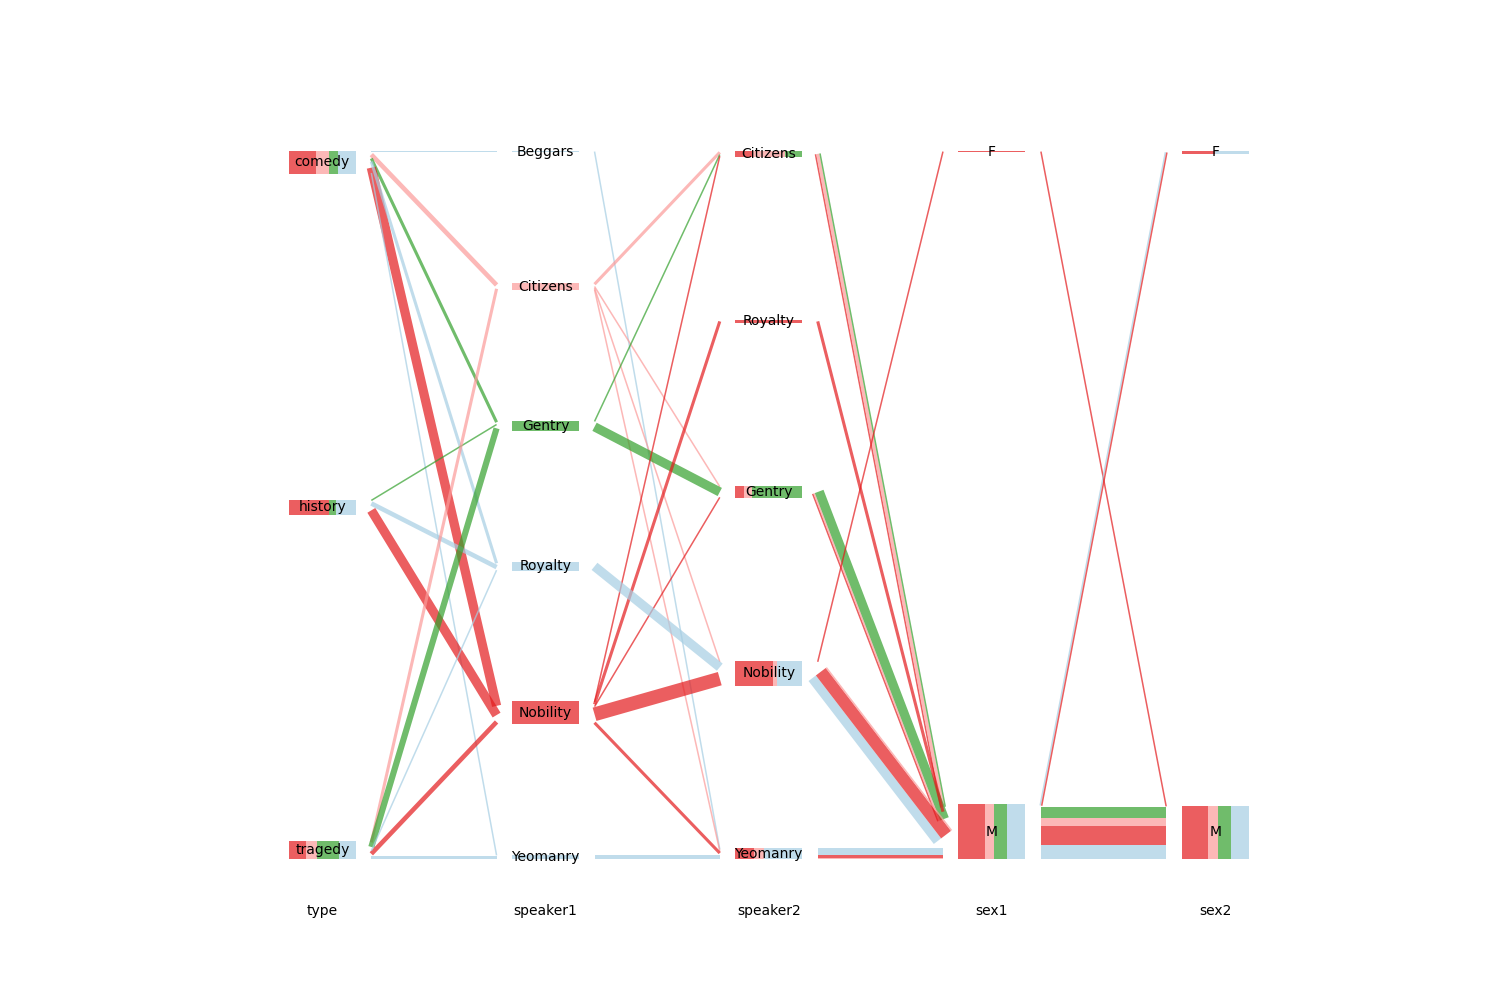
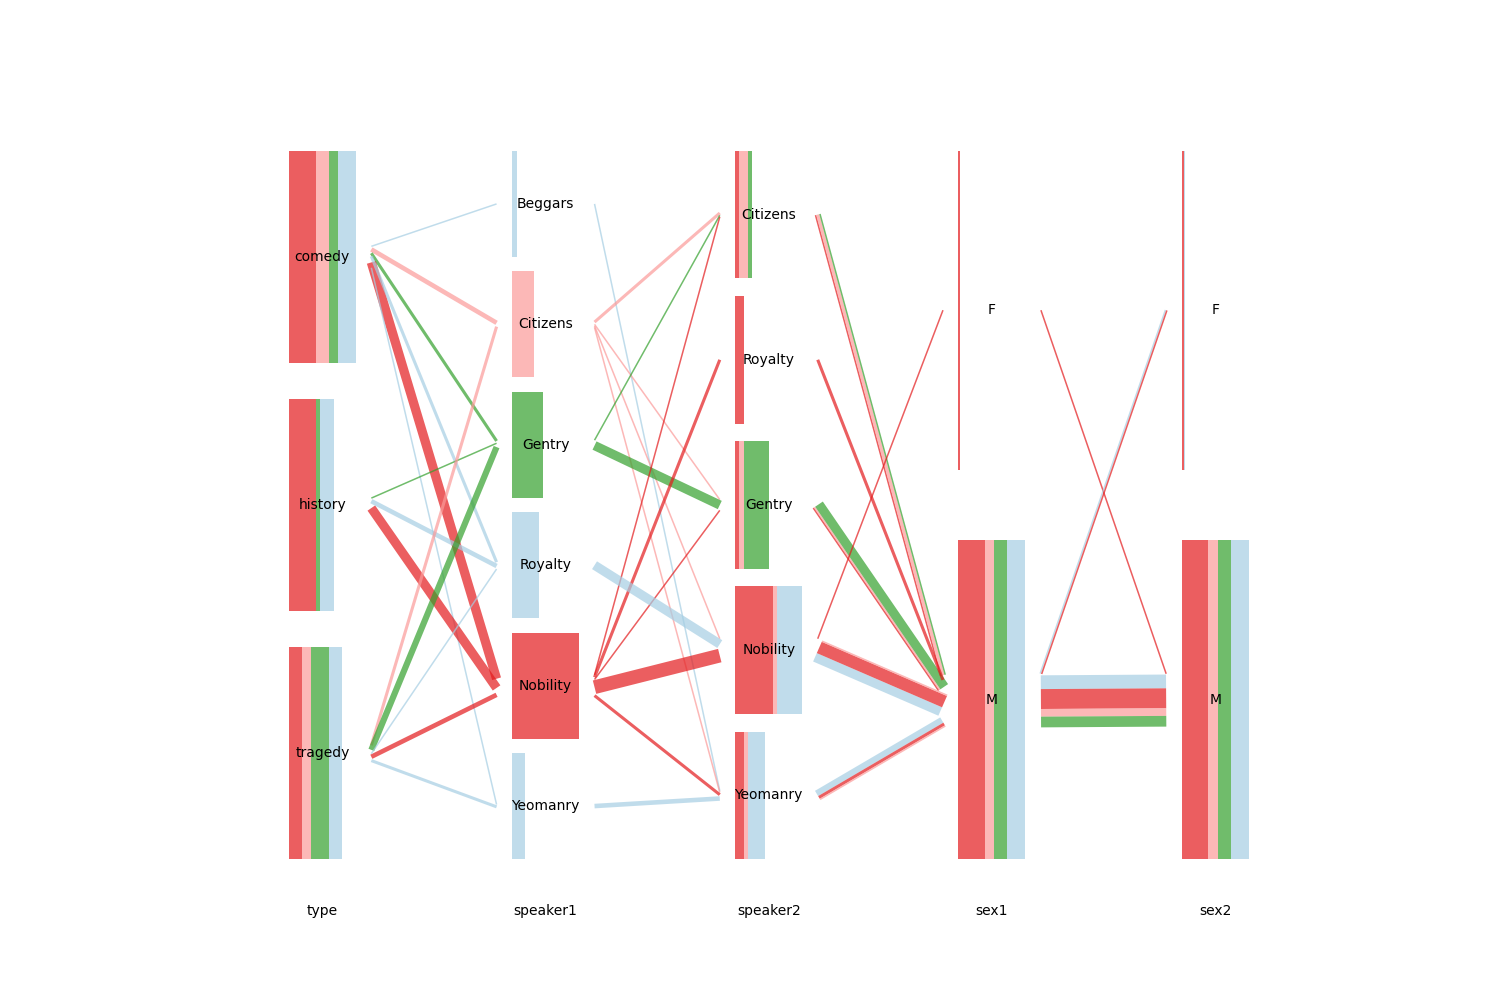
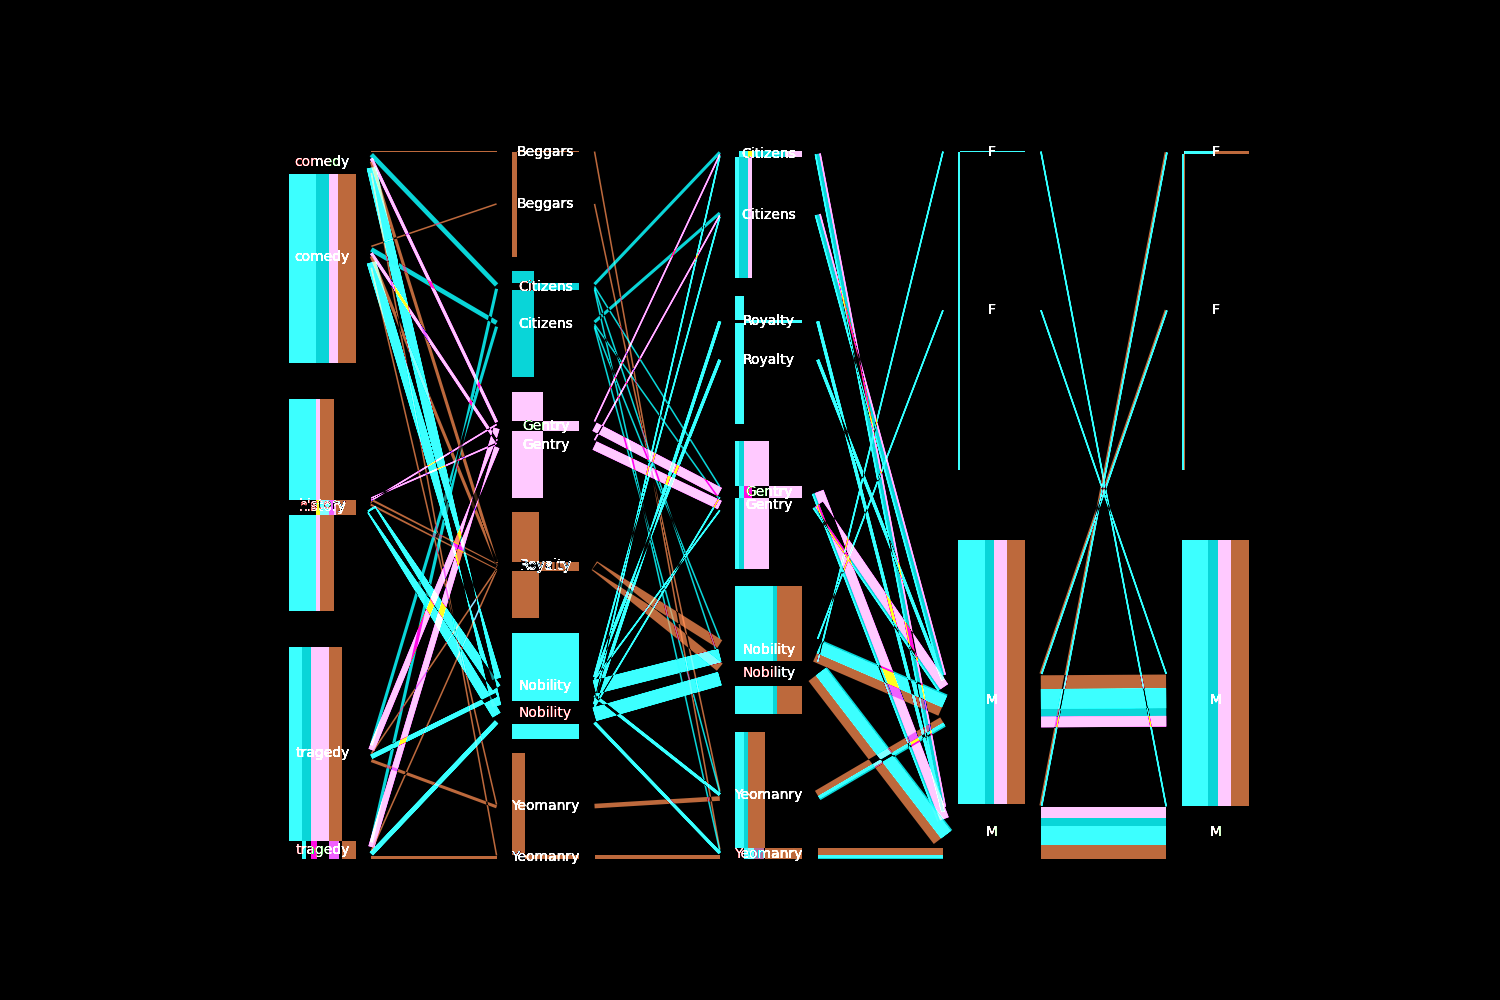

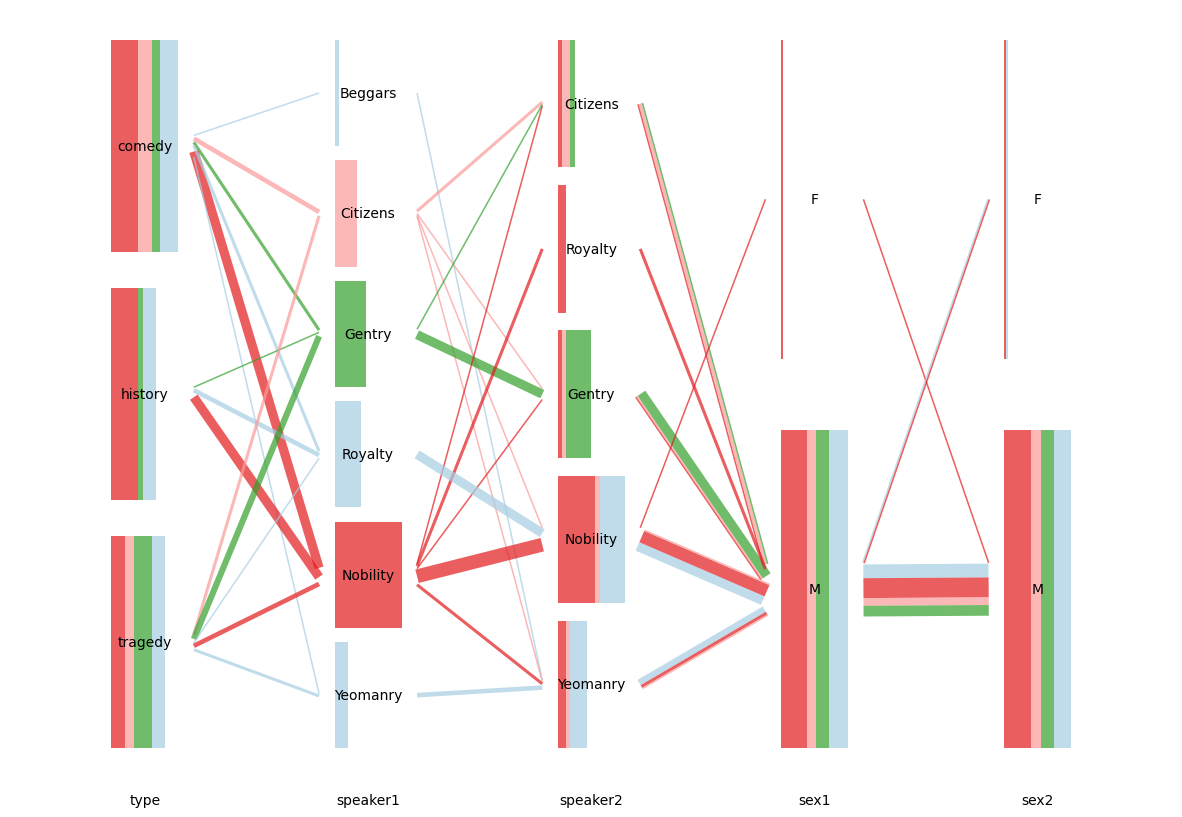

In [33]:
# highlight - value - categorical
filename = "highlight_var_categorical.png"
df = df_shakespeare

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var= [item for item in list(df) if item != "play_name"],
    display_figure=True,
    hi_var="speaker1",
    hi_value=["Nobility","Citizens","Gentry"],
    display_type={"type": "bar chart", "speaker1": "bar chart", "speaker2":"bar chart", "sex1":"bar chart", "sex2":"bar chart"},
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename),
    #shape="parallelogram"
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Highlight Categorical Variables Test", filename)

## Highlight range of values

In [34]:
# highlight - value - expression
# NOTE: this is wrong - the values should be rounded but they're not being rounded.
# NOTE: bar size is also different from when the range is not highlighted.
filename = "highlight_var_range.png"
df = df_asthma_2.dropna().iloc[:20, :]

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var= ["Age", "Gender", "Smoking", "PhysicalActivity", "FamilyHistoryAsthma"],
    display_figure=False,
    hi_var="PhysicalActivity",
    hi_value="6.5<x<8.2",
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Highlight Variable Range Test", filename)

Highlight Variable Range Test: No visual differences detected


c:\Users\shuan\Documents\personal\2025-hammock-plots\hammock_plot\hammock_plot\shapes.py:62: UserWarning: Overlap detected in unibar PhysicalActivity.
  warnings.warn(f"Overlap detected in unibar {unibar_name}.", UserWarning)


## Highlight boxes (horizontal)

In [35]:
# highlight - horizontal
filename = "highlight_horizontal.png"
df = df_shakespeare

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var= [item for item in list(df) if item != "play_name"],
    display_figure=False,
    hi_var="speaker1",
    hi_value=["Nobility","Citizens","Gentry"],
    hi_box="stacked",
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename),
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Highlight Box = Horizontal Test", filename)

Highlight Box = Horizontal Test: No visual differences detected


## Highlight missing variable

In [36]:
# highlight - missing = True
filename = "hi_missing.png"
df=df_diabetes

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    missing=True,
    display_figure=False,
    hi_var="satrate",
    hi_missing=True,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Missing Variable Test", filename)


Missing Variable Test: No visual differences detected


## Custom highlight colour list

In [37]:
# highlight - modified colours
# QUESTION: are these supposed to be rounded?

filename = "highlight_colours.png"
df = df_asthma_2.dropna().iloc[:20, :]

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var= ["Age", "Gender", "Smoking", "PhysicalActivity", "FamilyHistoryAsthma"],
    display_figure=False,
    hi_var = "Age",
    hi_value=[7, 21, 22, 26],
    colors=["red", "orange", "orange", "green"],
    missing=True,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Highlight Colours Test", filename)

c:\Users\shuan\Documents\personal\2025-hammock-plots\hammock_plot\hammock_plot\shapes.py:62: UserWarning: Overlap detected in unibar PhysicalActivity.
  warnings.warn(f"Overlap detected in unibar {unibar_name}.", UserWarning)


Highlight Colours Test: No visual differences detected


## Different default colour, alpha, connector color

In [38]:
# highlight - modified default colour
filename = "default_colour.png"
df = df_asthma_2.dropna().iloc[:20, :]

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var= ["Age", "Gender", "Smoking", "PhysicalActivity", "FamilyHistoryAsthma"],
    display_figure=False,
    default_color="#888888",
    connector_color="Blue",
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename),
    alpha=0.5,
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Default Colour Test", filename)

Default Colour Test: No visual differences detected


c:\Users\shuan\Documents\personal\2025-hammock-plots\hammock_plot\hammock_plot\shapes.py:62: UserWarning: Overlap detected in unibar PhysicalActivity.
  warnings.warn(f"Overlap detected in unibar {unibar_name}.", UserWarning)


# Spacing & Layout tests
Test cases involving "spacing and layout" hammock plot methods (following the categories in README.md)

## Uni Fraction

In [39]:
# spacing & layout - bar width
filename = "bar_width.png"

df = df_asthma

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    uni_vfill=1,
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Uni Fraction Test", filename)

c:\Users\shuan\Documents\personal\2025-hammock-plots\hammock_plot\hammock_plot\shapes.py:62: UserWarning: Overlap detected in unibar hospitalizations.
  warnings.warn(f"Overlap detected in unibar {unibar_name}.", UserWarning)
c:\Users\shuan\Documents\personal\2025-hammock-plots\hammock_plot\hammock_plot\shapes.py:62: UserWarning: Overlap detected in unibar gender.
  warnings.warn(f"Overlap detected in unibar {unibar_name}.", UserWarning)
c:\Users\shuan\Documents\personal\2025-hammock-plots\hammock_plot\hammock_plot\shapes.py:62: UserWarning: Overlap detected in unibar comorbidities.
  warnings.warn(f"Overlap detected in unibar {unibar_name}.", UserWarning)


Uni Fraction Test: No visual differences detected


## Connector Fraction

In [40]:
# spacing & layout - connector_fraction
filename = "connector_fraction.png"

df = df_shakespeare

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    uni_vfill=0.7,
    connector_fraction=0.05,
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Connector Fraction Test", filename)

Connector Fraction Test: No visual differences detected


## Label uni_hfill

In [41]:
# spacing & layout - horizontal fill
filename = "uni_hfill.png"

df = df_asthma

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    uni_hfill=.9,
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Display Label Test", filename)

Display Label Test: No visual differences detected


## Label options

In [42]:
# spacing & layout - label options (matplotlib)
filename = "label-opts.png"

df = df_asthma

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    label_options={"comorbidities": {"fontstyle": "italic", "fontsize": 12,},
                   "group":{"fontweight": "bold","fontsize": 14,"rotation": 45,"color": "darkred"},
                   "gender":{"fontsize": 10,"color": "black","bbox": dict(facecolor="lightyellow",edgecolor="gray", boxstyle="round,pad=0.3")},},
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Label Options Test", filename)

Label Options Test: No visual differences detected


## Plot height

In [43]:
# spacing & layout - plot height
filename = "plot_height.png"

df = df_asthma

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    height=2,
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Display Label Test", filename)

Display Label Test: No visual differences detected


## Plot width

In [44]:
# spacing & layout - plot width
filename = "plot_width.png"

df = df_asthma

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    width=5,
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Display Label Test", filename)

Display Label Test: No visual differences detected


## Min bar height

In [45]:
# spacing & layout - min bar width
filename = "min_bar_height.png"

df = df_asthma

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    min_bar_height=15,
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Display Label Test", filename)

Display Label Test: No visual differences detected


c:\Users\shuan\Documents\personal\2025-hammock-plots\hammock_plot\hammock_plot\shapes.py:62: UserWarning: Overlap detected in unibar hospitalizations.
  warnings.warn(f"Overlap detected in unibar {unibar_name}.", UserWarning)
c:\Users\shuan\Documents\personal\2025-hammock-plots\hammock_plot\hammock_plot\shapes.py:62: UserWarning: Overlap detected in unibar comorbidities.
  warnings.warn(f"Overlap detected in unibar {unibar_name}.", UserWarning)


# Other tests
Test cases involving "other" hammock plot methods (following the categories in README.md)

## Shape

In [46]:
# other - shape
filename = "shape.png"

df = df_asthma

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    shape="parallelogram",
    connector_fraction=0.5,
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Display Label Test", filename)

Display Label Test: No visual differences detected


## Same scale

same scale - numerical

In [47]:
# other - same_scale - numeric
filename = "same_scale_numeric.png"

df = df_asthma

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    same_scale=["hospitalizations", "comorbidities"],
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Display Label Test", filename)

Display Label Test: No visual differences detected


same scale - categorical

Test failed: Significant difference found in Categorical Same Scale Test



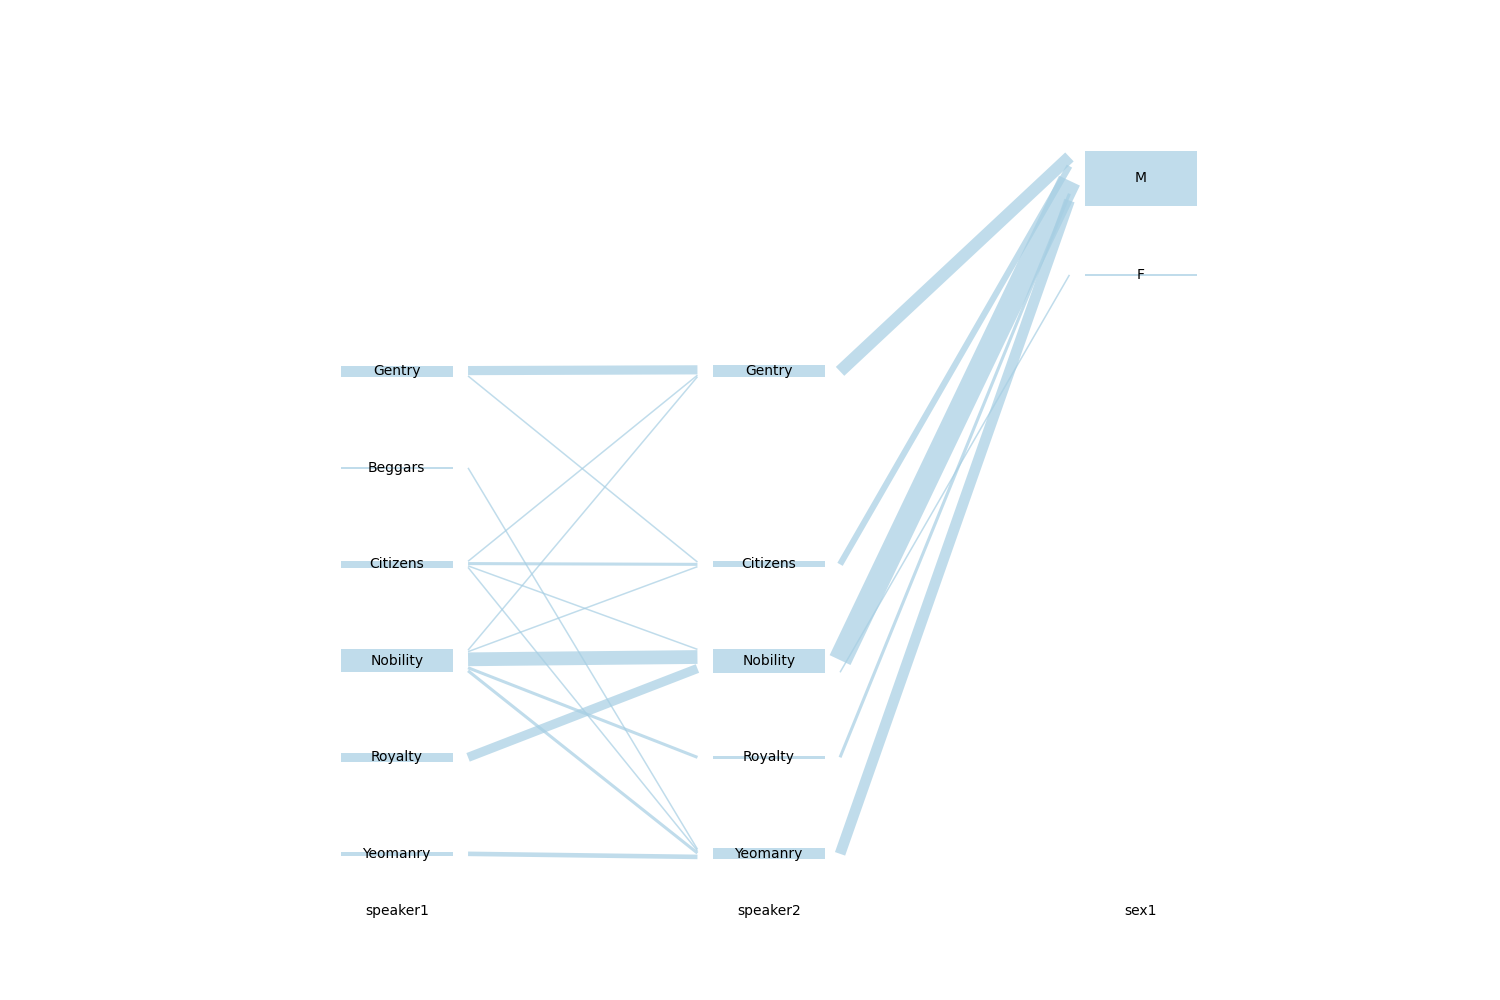
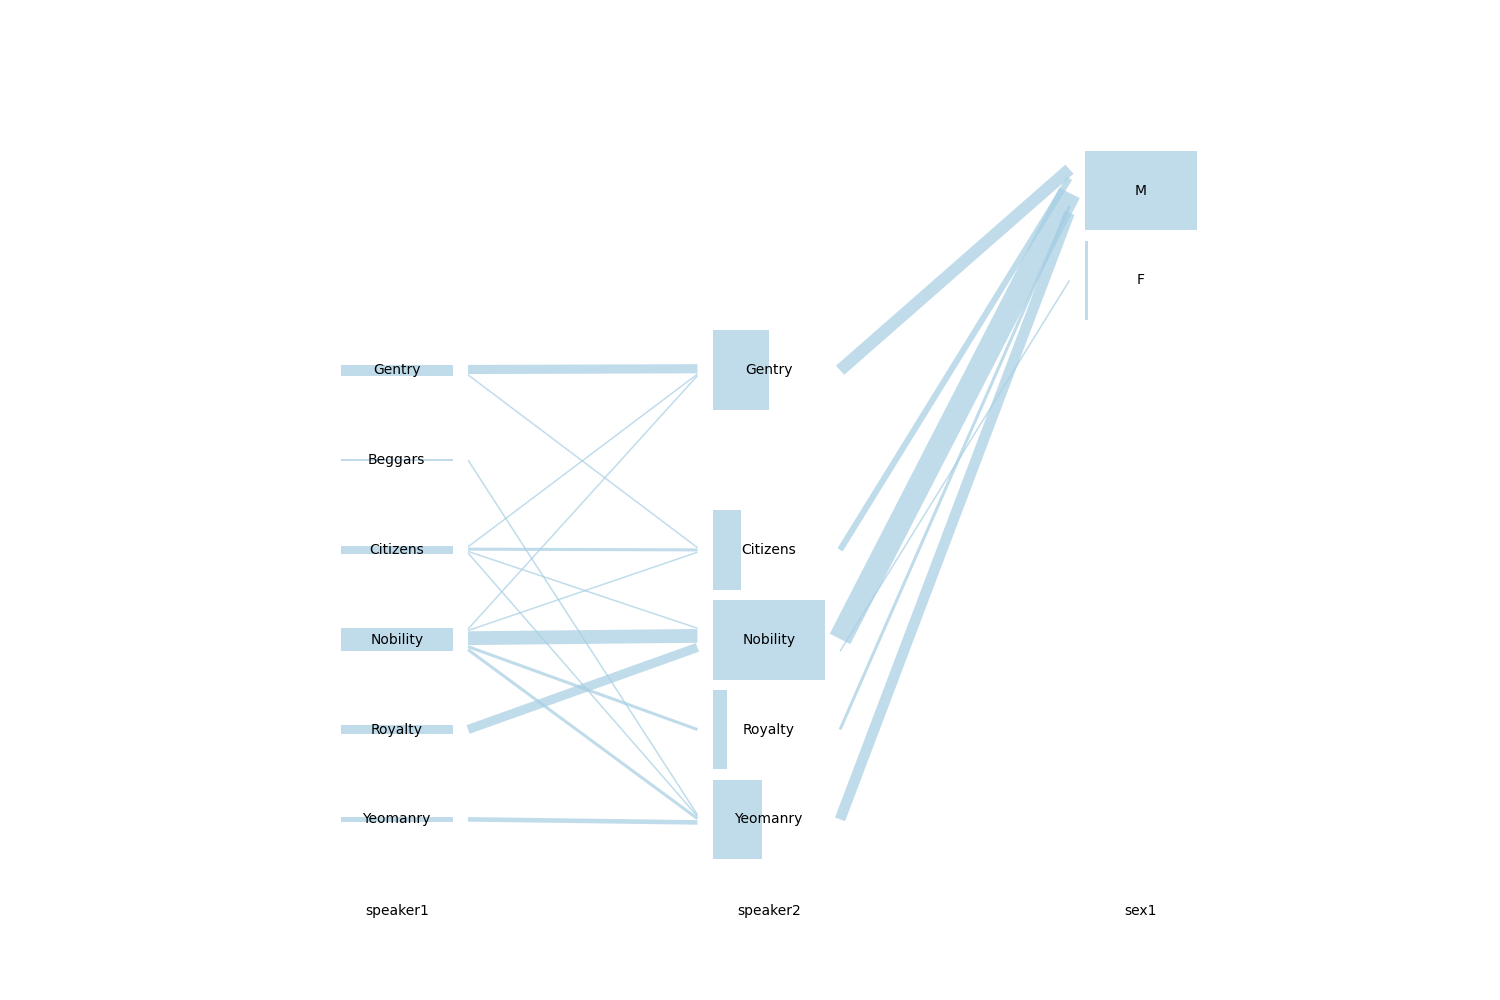
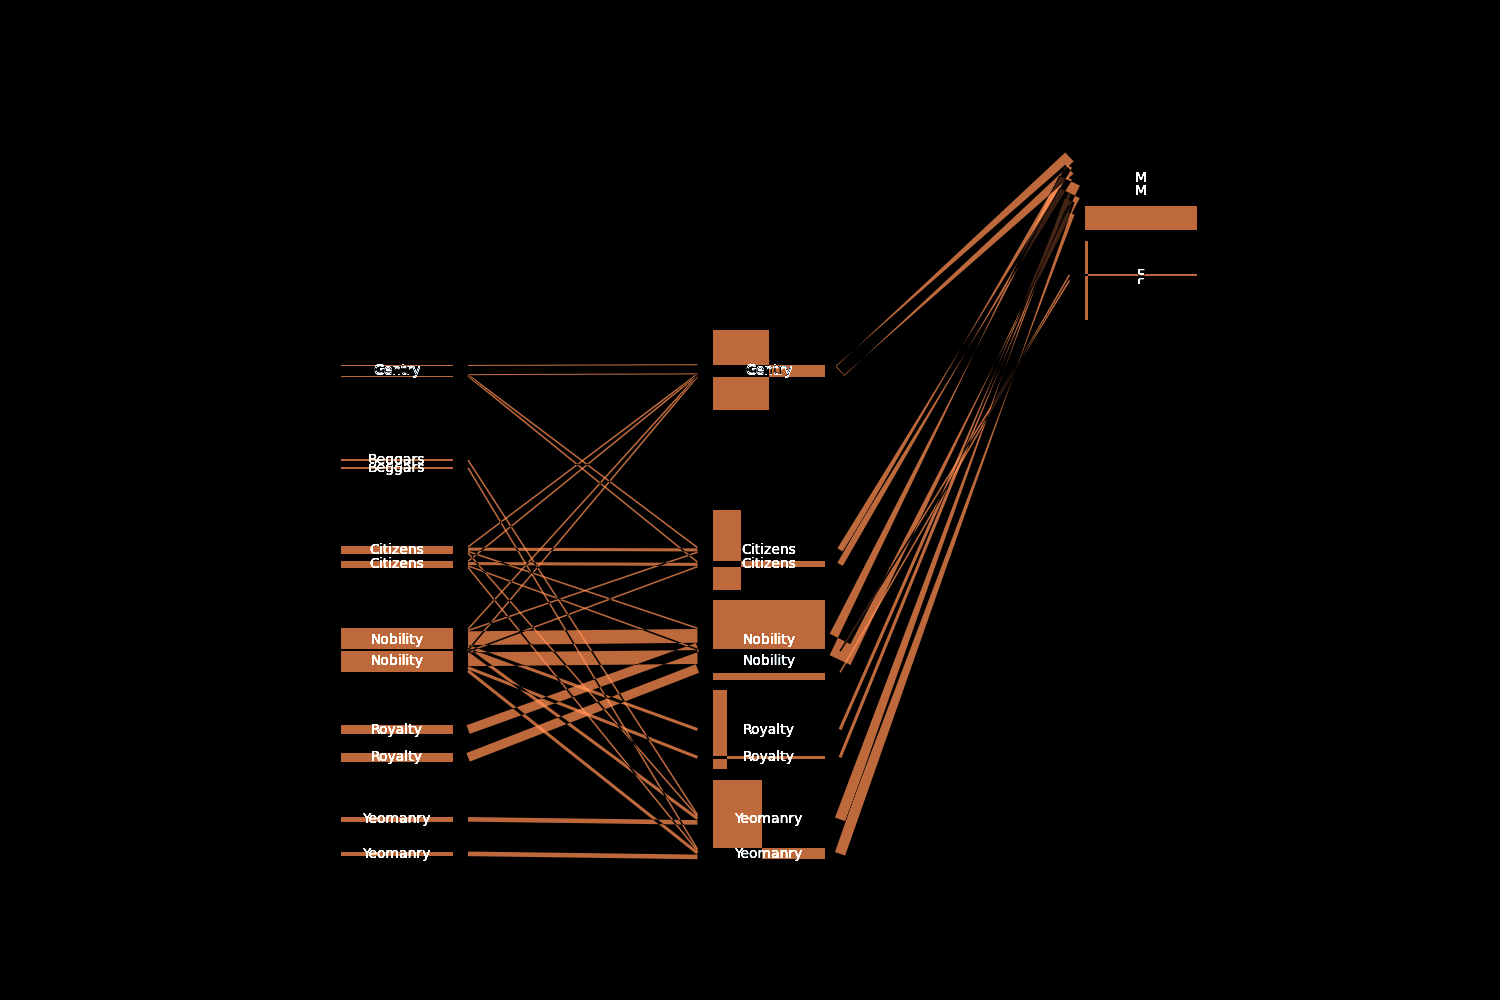

In [48]:
# other - same_scale - categorical
filename = "same_scale_categorical.png"

df = df_shakespeare

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=["speaker1", "speaker2","sex1"],
    same_scale=["speaker1", "speaker2", "sex1"],
    display_type={"sex1": "bar chart", "speaker2": "bar chart"},
    value_order={"speaker1": ["Yeomanry", "Royalty", "Nobility", "Citizens", "Beggars", "Gentry", "F", "M"]},
    display_figure=False,
    save_path=os.path.join(EXPECTED_PATH if GENERATE_EXPECTED else RESULT_PATH, filename)
)
if not GENERATE_EXPECTED: show_expected_vs_actual("Categorical Same Scale Test", filename)

## Display figure

<Axes: >

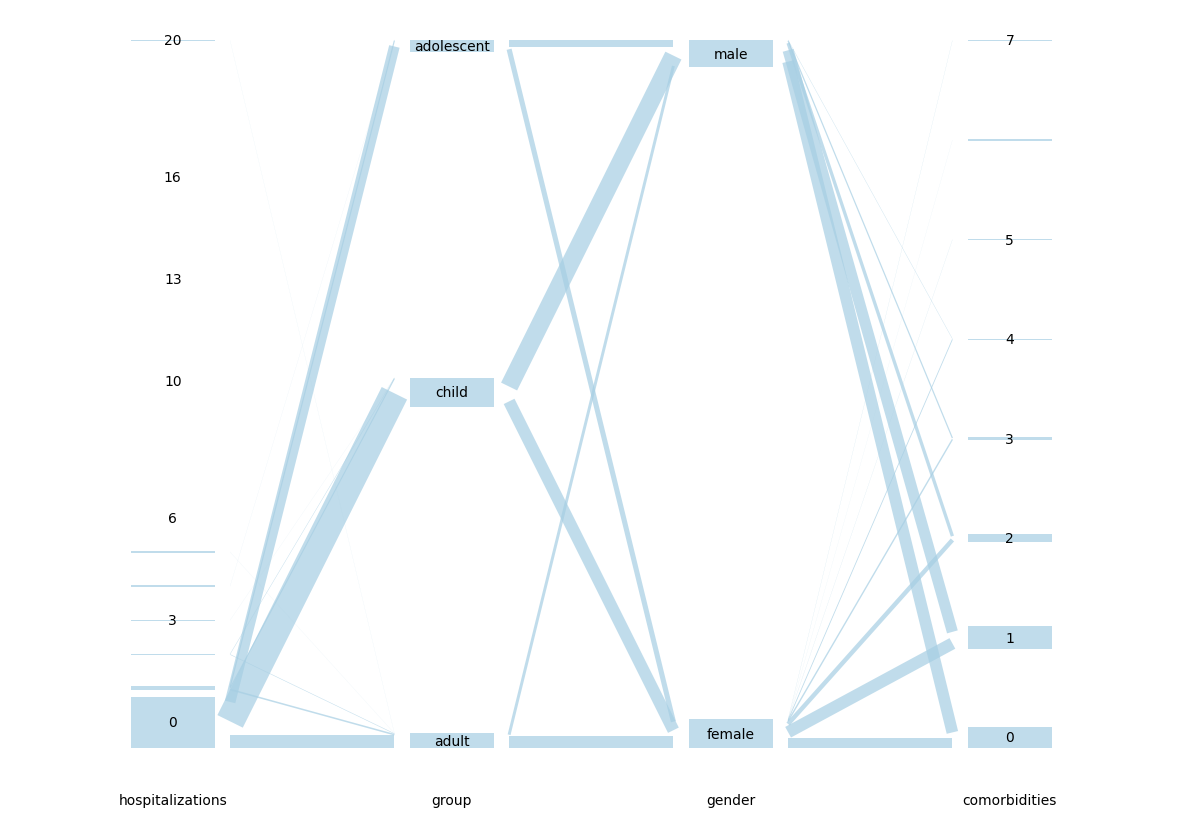

In [49]:
# other - display_figure
# success = figure displays successfully
df = df_asthma

hammock = hammock_plot.Hammock(df)

hammock.plot(
    var=list(df),
    display_figure=True
)